<a href="https://colab.research.google.com/github/Elshraby/GradProj4/blob/main/19_June_GPTs_GenAlgorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Vertical Axis Wind Turbine (VAWT) Surrogate Model using PyTorch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Load and preprocess data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)

    # Identify features
    categorical_features = ['Airfoil']
    numerical_features = ['Number of Blades', 'Cord Length', 'Height', 'Diameter', 'Pitch Angle', 'Freestream Velocity', 'Tip Speed Ratio']
    target = 'Power Coefficient'

    # Grouping constant parameters (designs)
    group_cols = [col for col in numerical_features if col != 'Tip Speed Ratio'] + categorical_features
    df['Design_ID'] = df[group_cols].astype(str).agg('-'.join, axis=1)

    # Split data
    X = df[categorical_features + numerical_features]
    y = df[target]

    # Preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        # Removed sparse=False as it's deprecated in newer scikit-learn versions
        ('cat', OneHotEncoder(), categorical_features)
    ])

    X_processed = preprocessor.fit_transform(X)
    return X_processed, y.values, preprocessor, df

# Define PyTorch dataset
class TurbineDataset(Dataset):
    def __init__(self, X, y):
        # Convert sparse matrix to dense numpy array before converting to tensor
        if hasattr(X, 'todense'):
            self.X = torch.tensor(X.todense(), dtype=torch.float32)
        else:
            self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define neural network model
class SurrogateModel(nn.Module):
    def __init__(self, input_dim):
        super(SurrogateModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Training function
def train_model(model, train_loader, val_loader, epochs=600, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                val_outputs = model(X_val)
                val_loss += criterion(val_outputs, y_val).item()
        val_losses.append(val_loss / len(val_loader))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

    return train_losses, val_losses

# Evaluation and visualization
def evaluate_and_visualize(model, X, y, df, preprocessor):
    model.eval()
    with torch.no_grad():
        # Convert sparse matrix X to dense numpy array before converting to tensor
        if hasattr(X, 'todense'):
            X_dense = X.todense()
        else:
            X_dense = X
        X_tensor = torch.tensor(X_dense, dtype=torch.float32)
        predictions = model(X_tensor).numpy().flatten()

    r2 = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    print(f"R^2 Score: {r2:.4f}, MSE: {mse:.4f}")

    # Visualize actual vs predicted
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y, y=predictions, alpha=0.6)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
    plt.xlabel('Actual Cp')
    plt.ylabel('Predicted Cp')
    plt.title('Actual vs Predicted Cp')
    plt.grid(True)
    plt.show()

    # Visualize Cp vs TSR curves for random designs
    df['Predicted_Cp'] = predictions
    sample_designs = df['Design_ID'].drop_duplicates().sample(3, random_state=42)
    for design in sample_designs:
        subset = df[df['Design_ID'] == design].sort_values('Tip Speed Ratio')
        plt.plot(subset['Tip Speed Ratio'], subset['Power Coefficient'], label=f"Actual {design[:10]}")
        plt.plot(subset['Tip Speed Ratio'], subset['Predicted_Cp'], '--', label=f"Predicted {design[:10]}")
    plt.xlabel('Tip Speed Ratio')
    plt.ylabel('Cp')
    plt.title('Cp vs Tip Speed Ratio for Sample Designs')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 0: Train Loss = 0.0096, Val Loss = 0.0064
Epoch 10: Train Loss = 0.0032, Val Loss = 0.0036
Epoch 20: Train Loss = 0.0022, Val Loss = 0.0026
Epoch 30: Train Loss = 0.0015, Val Loss = 0.0019
Epoch 40: Train Loss = 0.0014, Val Loss = 0.0019
Epoch 50: Train Loss = 0.0011, Val Loss = 0.0016
Epoch 60: Train Loss = 0.0010, Val Loss = 0.0016
Epoch 70: Train Loss = 0.0009, Val Loss = 0.0018
Epoch 80: Train Loss = 0.0008, Val Loss = 0.0021
Epoch 90: Train Loss = 0.0007, Val Loss = 0.0013
Epoch 100: Train Loss = 0.0008, Val Loss = 0.0014
Epoch 110: Train Loss = 0.0007, Val Loss = 0.0013
Epoch 120: Train Loss = 0.0006, Val Loss = 0.0012
Epoch 130: Train Loss = 0.0006, Val Loss = 0.0012
Epoch 140: Train Loss = 0.0006, Val Loss = 0.0011
Epoch 150: Train Loss = 0.0005, Val Loss = 0.0012
Epoch 160: Train Loss = 0.0006, Val Loss = 0.0011
Epoch 170: Train Loss = 0.0005, Val Loss = 0.0012
Epoch 180: Train Loss = 0.0005, Val Loss = 0.0010
Epoch 190: Train Loss = 0.0005, Val Loss = 0.0010
Epoch 200: 

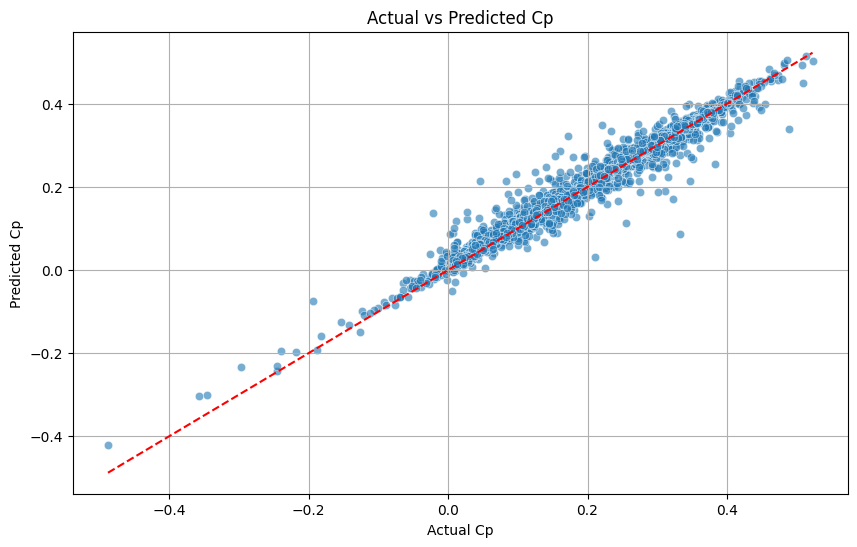

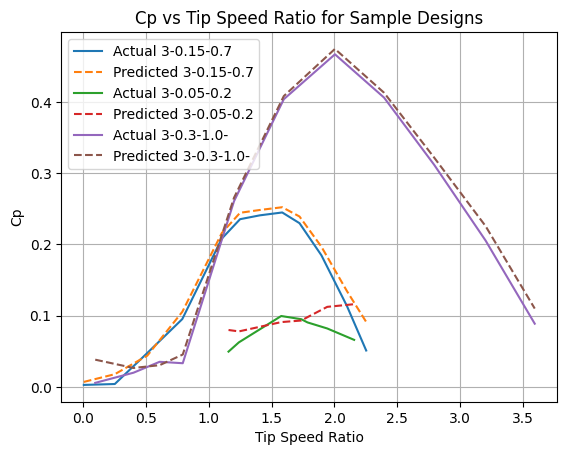

In [ ]:
# Main pipeline
if __name__ == '__main__':
    # Load data
    X, y, preprocessor, df = load_and_preprocess_data('Data.csv')

    # Train/Val split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # DataLoader
    train_dataset = TurbineDataset(X_train, y_train)
    val_dataset = TurbineDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Initialize model
    input_dim = X.shape[1]
    model = SurrogateModel(input_dim)

    # Train
    train_losses, val_losses = train_model(model, train_loader, val_loader)

    # Evaluate
    evaluate_and_visualize(model, X, y, df, preprocessor)

Epoch 0: Train Loss = 0.0148, Val Loss = 0.0073
Epoch 10: Train Loss = 0.0039, Val Loss = 0.0047
Epoch 20: Train Loss = 0.0026, Val Loss = 0.0031
Epoch 30: Train Loss = 0.0020, Val Loss = 0.0024
Epoch 40: Train Loss = 0.0016, Val Loss = 0.0020
Epoch 50: Train Loss = 0.0014, Val Loss = 0.0020
Epoch 60: Train Loss = 0.0013, Val Loss = 0.0017
Epoch 70: Train Loss = 0.0011, Val Loss = 0.0017
Epoch 80: Train Loss = 0.0009, Val Loss = 0.0016
Epoch 90: Train Loss = 0.0009, Val Loss = 0.0015
Epoch 100: Train Loss = 0.0008, Val Loss = 0.0018
Epoch 110: Train Loss = 0.0008, Val Loss = 0.0014
Epoch 120: Train Loss = 0.0007, Val Loss = 0.0014
Epoch 130: Train Loss = 0.0007, Val Loss = 0.0013
Epoch 140: Train Loss = 0.0007, Val Loss = 0.0012
Epoch 150: Train Loss = 0.0007, Val Loss = 0.0013
Epoch 160: Train Loss = 0.0006, Val Loss = 0.0012
Epoch 170: Train Loss = 0.0005, Val Loss = 0.0014
Epoch 180: Train Loss = 0.0006, Val Loss = 0.0012
Epoch 190: Train Loss = 0.0005, Val Loss = 0.0012
Epoch 200: 

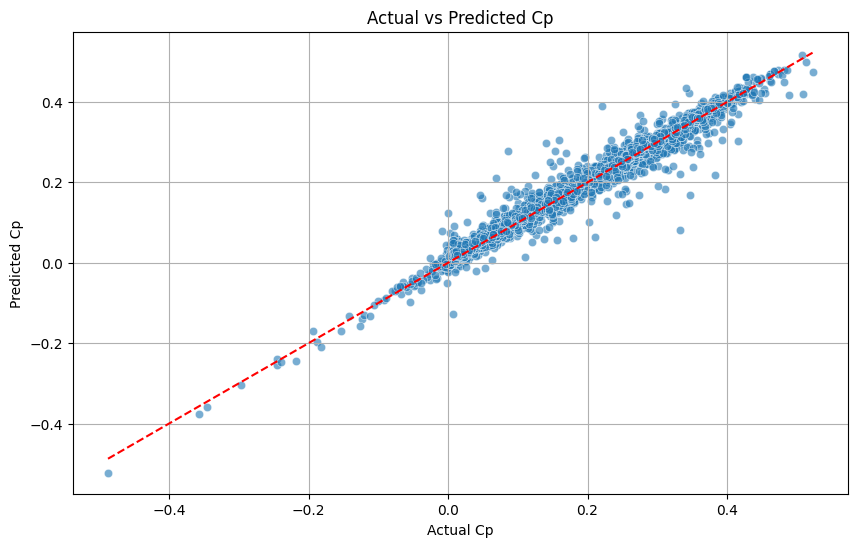

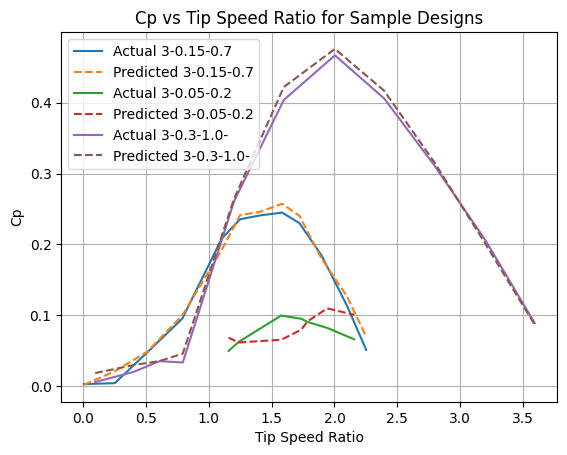

Generation 0, Best Cp: 0.4871
Generation 1, Best Cp: 0.4871
Generation 2, Best Cp: 0.4948
Generation 3, Best Cp: 0.5100
Generation 4, Best Cp: 0.5100
Generation 5, Best Cp: 0.5245
Generation 6, Best Cp: 0.5537
Generation 7, Best Cp: 0.5537
Generation 8, Best Cp: 0.5763
Generation 9, Best Cp: 0.5763
Generation 10, Best Cp: 0.5787
Generation 11, Best Cp: 0.5787
Generation 12, Best Cp: 0.5787
Generation 13, Best Cp: 0.5787
Generation 14, Best Cp: 0.5787
Generation 15, Best Cp: 0.5791
Generation 16, Best Cp: 0.5791
Generation 17, Best Cp: 0.5791
Generation 18, Best Cp: 0.5791
Generation 19, Best Cp: 0.5791
Generation 20, Best Cp: 0.5791
Generation 21, Best Cp: 0.5792
Generation 22, Best Cp: 0.5792
Generation 23, Best Cp: 0.5792
Generation 24, Best Cp: 0.5792
Generation 25, Best Cp: 0.5792
Generation 26, Best Cp: 0.5798
Generation 27, Best Cp: 0.5798
Generation 28, Best Cp: 0.5798
Generation 29, Best Cp: 0.5866
Generation 30, Best Cp: 0.5866
Generation 31, Best Cp: 0.5866
Generation 32, Bes

In [ ]:
# Vertical Axis Wind Turbine (VAWT) Surrogate Model using PyTorch

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random

# Load and preprocess data
def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)

    # Identify features
    categorical_features = ['Airfoil']
    numerical_features = ['Number of Blades', 'Cord Length', 'Height', 'Diameter', 'Pitch Angle', 'Freestream Velocity', 'Tip Speed Ratio']
    target = 'Power Coefficient'

    # Grouping constant parameters (designs)
    group_cols = [col for col in numerical_features if col != 'Tip Speed Ratio'] + categorical_features
    df['Design_ID'] = df[group_cols].astype(str).agg('-'.join, axis=1)

    # Split data
    X = df[categorical_features + numerical_features]
    y = df[target]

    # Preprocessing pipeline
    preprocessor = ColumnTransformer([
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ])

    X_processed = preprocessor.fit_transform(X)
    return X_processed, y.values, preprocessor, df

# Define PyTorch dataset
class TurbineDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Define neural network model
class SurrogateModel(nn.Module):
    def __init__(self, input_dim):
        super(SurrogateModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# Training function
def train_model(model, train_loader, val_loader, epochs=500, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val, y_val in val_loader:
                val_outputs = model(X_val)
                val_loss += criterion(val_outputs, y_val).item()
        val_losses.append(val_loss / len(val_loader))

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Train Loss = {train_losses[-1]:.4f}, Val Loss = {val_losses[-1]:.4f}")

    return train_losses, val_losses

# Evaluation and visualization
def evaluate_and_visualize(model, X, y, df, preprocessor):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.tensor(X, dtype=torch.float32)
        predictions = model(X_tensor).numpy().flatten()

    r2 = r2_score(y, predictions)
    mse = mean_squared_error(y, predictions)
    print(f"R^2 Score: {r2:.4f}, MSE: {mse:.4f}")

    # Visualize actual vs predicted
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y, y=predictions, alpha=0.6)
    plt.plot([min(y), max(y)], [min(y), max(y)], 'r--')
    plt.xlabel('Actual Cp')
    plt.ylabel('Predicted Cp')
    plt.title('Actual vs Predicted Cp')
    plt.grid(True)
    plt.show()

    # Visualize Cp vs TSR curves for random designs
    df['Predicted_Cp'] = predictions
    sample_designs = df['Design_ID'].drop_duplicates().sample(3, random_state=42)
    for design in sample_designs:
        subset = df[df['Design_ID'] == design].sort_values('Tip Speed Ratio')
        plt.plot(subset['Tip Speed Ratio'], subset['Power Coefficient'], label=f"Actual {design[:10]}")
        plt.plot(subset['Tip Speed Ratio'], subset['Predicted_Cp'], '--', label=f"Predicted {design[:10]}")
    plt.xlabel('Tip Speed Ratio')
    plt.ylabel('Cp')
    plt.title('Cp vs Tip Speed Ratio for Sample Designs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Genetic Algorithm for Optimization
def genetic_algorithm(model, preprocessor, airfoil_options, bounds, population_size=30, generations=50, mutation_rate=0.1):
    num_params = len(bounds)

    def generate_individual():
        airfoil = random.choice(airfoil_options)
        params = [random.uniform(low, high) for (low, high) in bounds]
        return [airfoil] + params

    def evaluate_individual(ind):
        airfoil = [ind[0]]
        features = ind[1:]
        tsr_range = np.linspace(1, 10, 20)
        best_cp = 0
        for tsr in tsr_range:
            input_df = pd.DataFrame([[*airfoil, *features, tsr]], columns=['Airfoil', 'Number of Blades', 'Cord Length', 'Height', 'Diameter', 'Pitch Angle', 'Freestream Velocity', 'Tip Speed Ratio'])
            x_input = preprocessor.transform(input_df)
            with torch.no_grad():
                prediction = model(torch.tensor(x_input, dtype=torch.float32)).item()
            if prediction > best_cp:
                best_cp = prediction
        return best_cp

    def mutate(ind):
        if random.random() < mutation_rate:
            ind[0] = random.choice(airfoil_options)
        for i in range(1, len(ind)):
            if random.random() < mutation_rate:
                low, high = bounds[i-1]
                ind[i] = random.uniform(low, high)
        return ind

    def crossover(parent1, parent2):
        crossover_point = random.randint(1, num_params)
        child1 = parent1[:crossover_point] + parent2[crossover_point:]
        child2 = parent2[:crossover_point] + parent1[crossover_point:]
        return child1, child2

    population = [generate_individual() for _ in range(population_size)]
    for gen in range(generations):
        population.sort(key=evaluate_individual, reverse=True)
        print(f"Generation {gen}, Best Cp: {evaluate_individual(population[0]):.4f}")
        next_gen = population[:population_size//2]
        while len(next_gen) < population_size:
            parents = random.sample(next_gen, 2)
            offspring = crossover(parents[0], parents[1])
            next_gen.extend([mutate(o) for o in offspring])
        population = next_gen[:population_size]

    best_individual = max(population, key=evaluate_individual)
    print("Best Configuration Found:", best_individual)
    print("Best Predicted Cp:", evaluate_individual(best_individual))

# Main pipeline
if __name__ == '__main__':
    # Load data
    X, y, preprocessor, df = load_and_preprocess_data('Data.csv')

    # Train/Val split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # DataLoader
    train_dataset = TurbineDataset(X_train, y_train)
    val_dataset = TurbineDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # Initialize model
    input_dim = X.shape[1]
    model = SurrogateModel(input_dim)

    # Train
    train_losses, val_losses = train_model(model, train_loader, val_loader)

    # Evaluate
    evaluate_and_visualize(model, X, y, df, preprocessor)

    # Run Genetic Algorithm
    airfoil_options = df['Airfoil'].unique().tolist()
    bounds = [
        (3, 3),          # Number of Blades (changed from 3 to (3, 3) to make it a tuple)
        (0.05, 0.2),     # Cord Length
        (0.3, 2.0),      # Height
        (0.3, 3.0),      # Diameter
        (-2, 2),        # Pitch Angle
        (10, 10)          # Freestream Velocity (changed from 10 to (10, 10) to make it a tuple)
    ]
    genetic_algorithm(model, preprocessor, airfoil_options, bounds)
